In [33]:
from plyfile import PlyData
import numpy as np
import random
import time

-144.83324105145 -230.43891835513 609.45419143394 921.77644843318


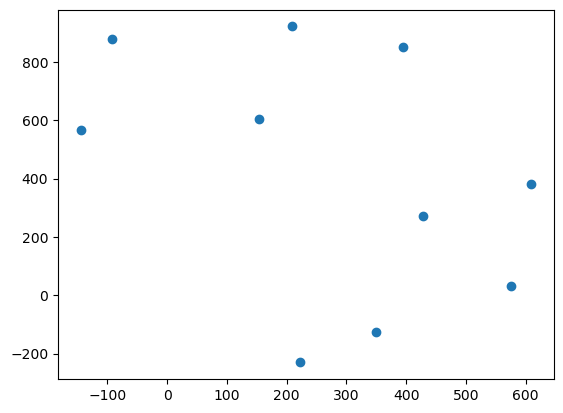

In [34]:
from matplotlib import pyplot as plt
filename = "points_3.ply"
plyData = PlyData.read(filename)
points=plyData["vertex"].data
points = [np.array(point.tolist(), dtype="float64") for point in points]
x_coords, y_coords = zip(*points)
plt.plot(x_coords, y_coords, marker="o", linestyle="None")
min_x = min(x_coords)
max_x = max(x_coords)
min_y = min(y_coords)
max_y = max(y_coords)
mid_x = (min_x + max_x)/2
mid_y = (min_y + max_y)/2
print(min_x,min_y,max_x,max_y)

In [35]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y


class Node:
  def __init__(self, min_point, max_point, children, parent):
    self.children = children
    self.min_point = min_point
    self.max_point = max_point
    self.parent = parent
    self.nodes = []

  def is_leaf(self):
    return len(self.nodes) == 0

  def __str__(self):
    return str(self.min_point)+", " + str(self.max_point)


  def split(self, max_leaf_children):
    if(len(self.children) <= max_leaf_children):
      return

    mid_x = (self.min_point[0] + self.max_point[0]) // 2
    mid_y = (self.min_point[1] + self.max_point[1]) // 2

    ne_points = [(x,y) for (x,y) in self.children if x > mid_x and y > mid_y]
    ne_node = Node((mid_x, mid_y),self.max_point, ne_points, self)
    ne_node.split(max_leaf_children)

    nw_points = [(x,y) for (x,y) in self.children if x <= mid_x and y > mid_y]
    nw_node = Node((self.min_point[0], mid_y),(mid_x, self.max_point[1]), nw_points, self)
    nw_node.split(max_leaf_children)

    se_points = [(x,y) for (x,y) in self.children if x > mid_x and y <= mid_y]
    se_node = Node((mid_x, self.min_point[1]),(self.max_point[0], mid_y), se_points, self)
    se_node.split(max_leaf_children)

    sw_points = [(x,y) for (x,y) in self.children if x <= mid_x and y <= mid_y]
    sw_node = Node(self.min_point,(mid_x, mid_y), sw_points, self)
    sw_node.split(max_leaf_children)

    self.nodes = [[nw_node, ne_node], [sw_node, se_node]]


In [36]:
class QuadTree:
  def __init__(self, arr, max_leaf_children=32):
    x_coords, y_coords = zip(*arr)

    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)


    self.root = Node((min_x-1, min_y-1),(max_x+1, max_y+1), arr, None)
    self.root.split(max_leaf_children)
    self.leaves = self.get_leaves()

  def range_lines(self):
    return self.range_lines_helper(self.root)

  def range_lines_helper(self, root):
    if root == None:
      return []
    cur_lines = [root.min_point, (root.min_point[0], root.max_point[1]), root.max_point, (root.max_point[0], root.min_point[1]), root.min_point]
    res = [cur_lines]
    for pole in root.nodes:
      for node in pole:
        res += self.range_lines_helper(node)

    return res

  def get_leaves(self):
    return self.get_leaves_helper(self.root)

  def get_leaves_helper(self, root):
    if root is None:
      return []
    if root.is_leaf():
      return [root]

    res = []
    for pole in root.nodes:
      for node in pole:
        res += self.get_leaves_helper(node)

    return res

  def get_neighbor(self, node, dir):
    """
    direction - 
      0: North
      1: South
      2: West
      3: East
    """
    if node == self.root:
      return None

    if dir < 2:
      same_pole = node.parent.nodes[dir]
      opposite_pole = node.parent.nodes[1-dir]
    else:
      same_pole = [node.parent.nodes[0][dir%2], node.parent.nodes[1][dir%2]]
      opposite_pole = [node.parent.nodes[0][1-dir%2], node.parent.nodes[1][1-dir%2]]

    for i in range(2):
      if node == opposite_pole[i]:
        return same_pole[i]

    m = self.get_neighbor(node.parent, dir)
    if m is None or m.is_leaf():
      return m


    if dir < 2:
      m_opposite_pole = m.nodes[1-dir]
    else:

      m_opposite_pole = [m.nodes[0][1-dir%2], m.nodes[1][1-dir%2]]


    if node == same_pole[0]:
      return m_opposite_pole[0]

    return m_opposite_pole[1]


Measuring the time it takes to construct the quad-tree

In [37]:
max_num_nodes = 1
start_time = time.time()
quadTree = QuadTree(points,max_num_nodes)
end_time = time.time()

time_in_ms = (end_time - start_time)*1000
print(f"it takes {time_in_ms} ms to construct the tree")

it takes 0.48995018005371094 ms to construct the tree


### Visualizing the quad-tree

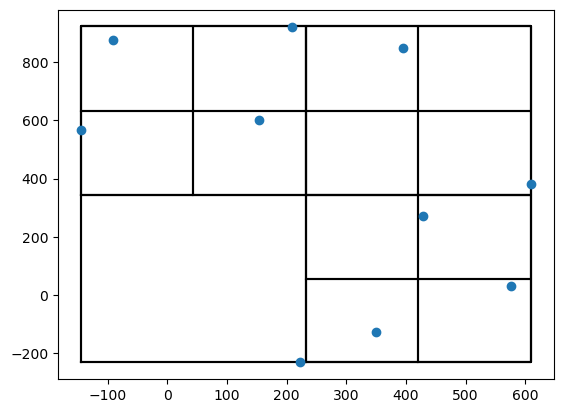

In [38]:
lines = quadTree.range_lines()
for square in lines:
  x_coords, y_coords = zip(*square)

  plt.plot(x_coords, y_coords, '-', color='black')
xp, yp = zip(*points)
plt.plot(xp, yp, marker="o", linestyle="None");

Getting the neighbor for a random leaf.
Take into consideration that the direction is represented as follows:
* North: 0
* South: 1
* West: 2
* East: 3

In [39]:
def are_neighbors(quadTree, node1, node2, dir):

  # when there is a neighbour
  if node2 is None:
    if dir==0:
     return node1.max_point[1] == quadTree.root.max_point[1]
    elif dir==1:
      return node1.min_point[1] == quadTree.root.min_point[1]
    elif dir==2:
      return node1.min_point[0] == quadTree.root.min_point[0]
    return node1.max_point[0] == quadTree.root.max_point[0]

  # to check if the found neighbor is the correct one
  if dir==0:
    return node1.max_point[1] == node2.min_point[1]
  elif dir==1:
    return node1.min_point[1] == node2.max_point[1]
  elif dir==2:
    return node1.min_point[0] == node2.max_point[0]
  return node1.max_point[0] == node2.min_point[0]


Choosing a random direction and a random leaf for measuring the time it takes to find this neighbor

In [40]:
dir = random.randint(0, 3)
leaf_id = random.randint(0, len(quadTree.leaves)-1)
leaf = quadTree.leaves[leaf_id]

initial_time = time.time()
neighbor = quadTree.get_neighbor(leaf, dir)
final_time = time.time()
time_in_ms = (final_time - initial_time)*1000
print(f"it takes {time_in_ms} ms to find the neighbor")

it takes 0.11587142944335938 ms to find the neighbor
